In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

pd.set_option('display.max_columns',200)
pd.set_option("display.max_info_rows", 800)
pd.set_option('display.max_info_columns',800)

from sklearn import set_config
set_config(transform_output='pandas')

In [2]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
    # Get the classification report
    report = classification_report(y_true, y_pred)
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    # create a confusion matrix  of raw counts
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
    axes[0].set_title("Raw Counts")
    # create a confusion matrix with the test data
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict


def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
    # Get predictions for training data
    y_train_pred = model.predict(X_train)
    # Call the helper function to obtain regression metrics for training data
    results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
    print()
    # Get predictions for test data
    y_test_pred = model.predict(X_test)
    # Call the helper function to obtain regression metrics for test data
    results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
    if output_dict == True:
        # Store results in a dataframe if ouput_frame is True
        results_dict = {'train':results_train,
                    'test': results_test}
        return results_dict

In [3]:
# Making new dataframe for Diabetes Risk
df = pd.read_csv('Data/NHANES_Diet_Diabetes_Risk.xls.csv')
df.head()

,SEQN,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,DBD100,DRQSPREP,DR1STY,DR1SKY,DRQSDIET,DRQSDT1,DRQSDT2,DRQSDT3,DRQSDT4,DRQSDT5,DRQSDT6,DRQSDT7,DRQSDT8,DRQSDT9,DRQSDT10,DRQSDT11,DRQSDT12,DRQSDT91,DR1TNUMF,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TATOA,DR1TRET,DR1TVARA,DR1TACAR,DR1TBCAR,DR1TCRYP,DR1TLYCO,DR1TLZ,DR1TVB1,DR1TVB2,DR1TNIAC,DR1TVB6,DR1TFOLA,DR1TFA,DR1TFF,DR1TFDFE,DR1TCHL,DR1TVB12,DR1TB12A,DR1TVC,DR1TVD,DR1TVK,DR1TCALC,DR1TPHOS,DR1TMAGN,DR1TIRON,DR1TZINC,DR1TCOPP,DR1TSODI,DR1TPOTA,DR1TSELE,DR1TCAFF,DR1TTHEO,DR1TALCO,DR1TMOIS,DR1TS040,DR1TS060,DR1TS080,DR1TS100,DR1TS120,DR1TS140,DR1TS160,DR1TS180,DR1TM161,DR1TM181,DR1TM201,DR1TM221,DR1TP182,DR1TP183,DR1TP184,DR1TP204,DR1TP205,DR1TP225,DR1TP226,DR1.300,DR1.320Z,DR1.330Z,DR1BWATZ,DR1TWS,DRD340,DRD350A,DRD350AQ,DRD350B,DRD350BQ,DRD350C,DRD350CQ,DRD350D,DRD350DQ,DRD350E,DRD350EQ,DRD350F,DRD350FQ,DRD350G,DRD350GQ,DRD350H,DRD350HQ,DRD350I,DRD350IQ,DRD350J,DRD350JQ,DRD350K,DRD360,DRD370A,DRD370AQ,DRD370B,DRD370BQ,DRD370C,DRD370CQ,DRD370D,DRD370DQ,DRD370E,DRD370EQ,DRD370F,DRD370FQ,DRD370G,DRD370GQ,DRD370H,DRD370HQ,DRD370I,DRD370IQ,DRD370J,DRD370JQ,DRD370K,DRD370KQ,DRD370L,DRD370LQ,DRD370M,DRD370MQ,DRD370N,DRD370NQ,DRD370O,DRD370OQ,DRD370P,DRD370PQ,DRD370Q,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V,Diabetes_Risk
0,73557,16888.32786,12930.89065,1,49.0,2.0,2.0,6.0,2.0,1.0,1.0,13.0,3.0,2.0,4.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,1574.0,43.63,239.59,176.47,10.8,52.81,17.819,18.493,8.829,209.0,3.92,0.0,70.0,110.0,60.0,304.0,278.0,1398.0,430.0,1.057,1.216,11.804,0.951,285.0,66.0,219.0,330.0,216.3,2.79,0.00,241.4,3.3,29.2,949.0,756.0,206.0,8.41,8.85,1.072,1323.0,2228.0,62.5,203.0,36.0,0.0,2701.79,0.219,0.099,0.103,0.153,0.346,1.221,9.694,5.408,1.173,16.796,0.121,0.001,7.932,0.769,0.000,0.094,0.001,0.000,0.010,2.0,960.0,960.0,0.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
1,73558,17932.14387,12684.14887,1,59.0,2.0,2.0,4.0,1.0,1.0,1.0,13.0,1.0,2.0,3.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,5062.0,338.13,423.78,44.99,16.7,124.29,53.408,35.481,20.505,2584.0,20.94,0.0,1477.0,1488.0,0.0,145.0,12.0,0.0,899.0,4.178,5.168,65.396,4.415,1243.0,601.0,641.0,1662.0,2149.0,21.45,0.00,2.3,15.2,23.4,3193.0,6427.0,903.0,26.88,30.36,4.130,9726.0,4930.0,715.8,240.0,0.0,119.0,6779.99,1.872,1.160,0.802,1.286,1.297,6.516,27.952,12.107,2.208,32.429,0.086,0.000,15.483,1.774,0.007,0.728,1.003,0.104,1.139,2.0,360.0,360.0,0.0,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,1.0,1.0,1.0,2.0,NaN,2.0,NaN,2.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,2
2,73559,59641.81293,39394.23671,1,49.0,2.0,2.0,18.0,6.0,1.0,1.0,13.0,1.0,1.0,2.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,27.0,1743.0,64.61,224.39,102.90,9.9,65.97,25.263,20.902,12.953,88.0,8.87,0.0,616.0,655.0,21.0,449.0,35.0,515.0,300.0,1.648,1.747,18.342,1.906,423.0,290.0,133.0,625.0,161.2,3.78,1.42,195.1,4.0,40.4,877.0,1198.0,210.0,17.57,8.98,0.949,2943.0,1694.0,98.3,45.0,71.0,0.0,3766.70,0.358,0.128,0.371,0.455,3.008,2.067,10.691,7.497,0.531,19.910,0.164,0.005,11.705,1.092,0.000,0.042,0.001,0.006,0.002,2.0,1254.0,0.0,1254.0,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,73561,59052.35703,39004.89299,1,63.0,2.0,2.0,18.0,1.0,1.0,1.0,13.0,4.0,Na

In [4]:
# Setting SEQN as index
df = df.set_index("SEQN")
df.head()

,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,DBD100,DRQSPREP,DR1STY,DR1SKY,DRQSDIET,DRQSDT1,DRQSDT2,DRQSDT3,DRQSDT4,DRQSDT5,DRQSDT6,DRQSDT7,DRQSDT8,DRQSDT9,DRQSDT10,DRQSDT11,DRQSDT12,DRQSDT91,DR1TNUMF,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TATOA,DR1TRET,DR1TVARA,DR1TACAR,DR1TBCAR,DR1TCRYP,DR1TLYCO,DR1TLZ,DR1TVB1,DR1TVB2,DR1TNIAC,DR1TVB6,DR1TFOLA,DR1TFA,DR1TFF,DR1TFDFE,DR1TCHL,DR1TVB12,DR1TB12A,DR1TVC,DR1TVD,DR1TVK,DR1TCALC,DR1TPHOS,DR1TMAGN,DR1TIRON,DR1TZINC,DR1TCOPP,DR1TSODI,DR1TPOTA,DR1TSELE,DR1TCAFF,DR1TTHEO,DR1TALCO,DR1TMOIS,DR1TS040,DR1TS060,DR1TS080,DR1TS100,DR1TS120,DR1TS140,DR1TS160,DR1TS180,DR1TM161,DR1TM181,DR1TM201,DR1TM221,DR1TP182,DR1TP183,DR1TP184,DR1TP204,DR1TP205,DR1TP225,DR1TP226,DR1.300,DR1.320Z,DR1.330Z,DR1BWATZ,DR1TWS,DRD340,DRD350A,DRD350AQ,DRD350B,DRD350BQ,DRD350C,DRD350CQ,DRD350D,DRD350DQ,DRD350E,DRD350EQ,DRD350F,DRD350FQ,DRD350G,DRD350GQ,DRD350H,DRD350HQ,DRD350I,DRD350IQ,DRD350J,DRD350JQ,DRD350K,DRD360,DRD370A,DRD370AQ,DRD370B,DRD370BQ,DRD370C,DRD370CQ,DRD370D,DRD370DQ,DRD370E,DRD370EQ,DRD370F,DRD370FQ,DRD370G,DRD370GQ,DRD370H,DRD370HQ,DRD370I,DRD370IQ,DRD370J,DRD370JQ,DRD370K,DRD370KQ,DRD370L,DRD370LQ,DRD370M,DRD370MQ,DRD370N,DRD370NQ,DRD370O,DRD370OQ,DRD370P,DRD370PQ,DRD370Q,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V,Diabetes_Risk
SEQN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
73557,16888.32786,12930.89065,1,49.0,2.0,2.0,6.0,2.0,1.0,1.0,13.0,3.0,2.0,4.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,1574.0,43.63,239.59,176.47,10.8,52.81,17.819,18.493,8.829,209.0,3.92,0.0,70.0,110.0,60.0,304.0,278.0,1398.0,430.0,1.057,1.216,11.804,0.951,285.0,66.0,219.0,330.0,216.3,2.79,0.00,241.4,3.3,29.2,949.0,756.0,206.0,8.41,8.85,1.072,1323.0,2228.0,62.5,203.0,36.0,0.0,2701.79,0.219,0.099,0.103,0.153,0.346,1.221,9.694,5.408,1.173,16.796,0.121,0.001,7.932,0.769,0.000,0.094,0.001,0.000,0.010,2.0,960.0,960.0,0.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
73558,17932.14387,12684.14887,1,59.0,2.0,2.0,4.0,1.0,1.0,1.0,13.0,1.0,2.0,3.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,5062.0,338.13,423.78,44.99,16.7,124.29,53.408,35.481,20.505,2584.0,20.94,0.0,1477.0,1488.0,0.0,145.0,12.0,0.0,899.0,4.178,5.168,65.396,4.415,1243.0,601.0,641.0,1662.0,2149.0,21.45,0.00,2.3,15.2,23.4,3193.0,6427.0,903.0,26.88,30.36,4.130,9726.0,4930.0,715.8,240.0,0.0,119.0,6779.99,1.872,1.160,0.802,1.286,1.297,6.516,27.952,12.107,2.208,32.429,0.086,0.000,15.483,1.774,0.007,0.728,1.003,0.104,1.139,2.0,360.0,360.0,0.0,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,1.0,1.0,1.0,2.0,NaN,2.0,NaN,2.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,2
73559,59641.81293,39394.23671,1,49.0,2.0,2.0,18.0,6.0,1.0,1.0,13.0,1.0,1.0,2.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,27.0,1743.0,64.61,224.39,102.90,9.9,65.97,25.263,20.902,12.953,88.0,8.87,0.0,616.0,655.0,21.0,449.0,35.0,515.0,300.0,1.648,1.747,18.342,1.906,423.0,290.0,133.0,625.0,161.2,3.78,1.42,195.1,4.0,40.4,877.0,1198.0,210.0,17.57,8.98,0.949,2943.0,1694.0,98.3,45.0,71.0,0.0,3766.70,0.358,0.128,0.371,0.455,3.008,2.067,10.691,7.497,0.531,19.910,0.164,0.005,11.705,1.092,0.000,0.042,0.001,0.006,0.002,2.0,1254.0,0.0,1254.0,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [21]:
# Taking peek at our target results
df['Diabetes_Risk'].value_counts()

0    5452
2     604
1     587
Name: Diabetes_Risk, dtype: int64

In [6]:
# Defining our X and Y for train test splitting
target = "Diabetes_Risk"
# Define X and y
y = df[target].copy()
X = df.drop(columns=[target]).copy()

In [7]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=28)
X_train.head()

,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,DBD100,DRQSPREP,DR1STY,DR1SKY,DRQSDIET,DRQSDT1,DRQSDT2,DRQSDT3,DRQSDT4,DRQSDT5,DRQSDT6,DRQSDT7,DRQSDT8,DRQSDT9,DRQSDT10,DRQSDT11,DRQSDT12,DRQSDT91,DR1TNUMF,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TATOA,DR1TRET,DR1TVARA,DR1TACAR,DR1TBCAR,DR1TCRYP,DR1TLYCO,DR1TLZ,DR1TVB1,DR1TVB2,DR1TNIAC,DR1TVB6,DR1TFOLA,DR1TFA,DR1TFF,DR1TFDFE,DR1TCHL,DR1TVB12,DR1TB12A,DR1TVC,DR1TVD,DR1TVK,DR1TCALC,DR1TPHOS,DR1TMAGN,DR1TIRON,DR1TZINC,DR1TCOPP,DR1TSODI,DR1TPOTA,DR1TSELE,DR1TCAFF,DR1TTHEO,DR1TALCO,DR1TMOIS,DR1TS040,DR1TS060,DR1TS080,DR1TS100,DR1TS120,DR1TS140,DR1TS160,DR1TS180,DR1TM161,DR1TM181,DR1TM201,DR1TM221,DR1TP182,DR1TP183,DR1TP184,DR1TP204,DR1TP205,DR1TP225,DR1TP226,DR1.300,DR1.320Z,DR1.330Z,DR1BWATZ,DR1TWS,DRD340,DRD350A,DRD350AQ,DRD350B,DRD350BQ,DRD350C,DRD350CQ,DRD350D,DRD350DQ,DRD350E,DRD350EQ,DRD350F,DRD350FQ,DRD350G,DRD350GQ,DRD350H,DRD350HQ,DRD350I,DRD350IQ,DRD350J,DRD350JQ,DRD350K,DRD360,DRD370A,DRD370AQ,DRD370B,DRD370BQ,DRD370C,DRD370CQ,DRD370D,DRD370DQ,DRD370E,DRD370EQ,DRD370F,DRD370FQ,DRD370G,DRD370GQ,DRD370H,DRD370HQ,DRD370I,DRD370IQ,DRD370J,DRD370JQ,DRD370K,DRD370KQ,DRD370L,DRD370LQ,DRD370M,DRD370MQ,DRD370N,DRD370NQ,DRD370O,DRD370OQ,DRD370P,DRD370PQ,DRD370Q,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V
SEQN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
78468,35086.924490,175842.77080,1,14.0,2.0,2.0,1.0,1.0,1.0,1.0,13.0,4.0,NaN,3.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,1961.0,66.44,260.27,114.11,16.4,76.18,21.055,29.104,20.220,425.0,11.40,0.0,465.0,679.0,777.0,2122.0,104.0,0.0,1005.0,1.470,1.687,23.952,1.661,319.0,181.0,137.0,445.0,337.5,4.05,1.01,40.8,5.4,104.1,982.0,1250.0,261.0,20.18,6.62,0.993,3552.0,1831.0,144.6,9.0,233.0,0.0,1847.25,0.228,0.175,0.128,0.319,0.376,1.186,13.111,4.697,0.566,27.963,0.395,0.019,17.709,1.969,0.003,0.213,0.026,0.017,0.162,2.0,747.0,0.0,747.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,1.0,2.0,NaN,2.0
75491,9760.797052,28587.09647,1,49.0,2.0,2.0,5.0,6.0,1.0,1.0,13.0,4.0,NaN,2.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,1173.0,44.06,134.32,65.85,7.4,41.64,16.520,14.657,7.476,76.0,3.84,0.0,241.0,298.0,12.0,660.0,16.0,4144.0,279.0,0.653,1.467,8.819,0.678,247.0,96.0,149.0,313.0,158.3,3.01,0.00,48.8,3.4,40.2,1080.0,1084.0,165.0,4.87,6.12,0.568,1746.0,1682.0,52.8,187.0,20.0,14.0,1974.08,0.396,0.310,0.208,0.508,0.603,2.060,8.256,3.549,0.569,13.009,0.127,0.004,6.567,0.782,0.004,0.034,0.009,0.011,0.002,2.0,435.0,435.0,0.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82763,120877.644900,215938.54900,1,71.0,2.0,2.0,6.0,2.0,1.0,1.0,13.0,1.0,1.0,2.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,1131.0,50.72,135.92,57.41,12.9,43.95,18.176,16.054,6.633,110.0,2.78,0.0,486.0,520.0,5.0,435.0,9.0,2716.0,845.0,0.936,1.822,10.883,1.126,173.0,69.0,103.0,222.0,217.3,5.78,0.84,3.7,5.1,37.8,1063.0,1307.0,191.0,9.02,6.86,0.497,2259.0,1610.0,62.9,24.0,12.0,0.0,1194.69,0.425,0.287,0.172,0.424,0.469,1.813,9.874,4.336,0.961,14.612,0.228,0.002,6.027,0.389,0.003,0.073,0.012,0.012,0.006,2.0,360.0,360.0,0.0,1.0,1.0,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

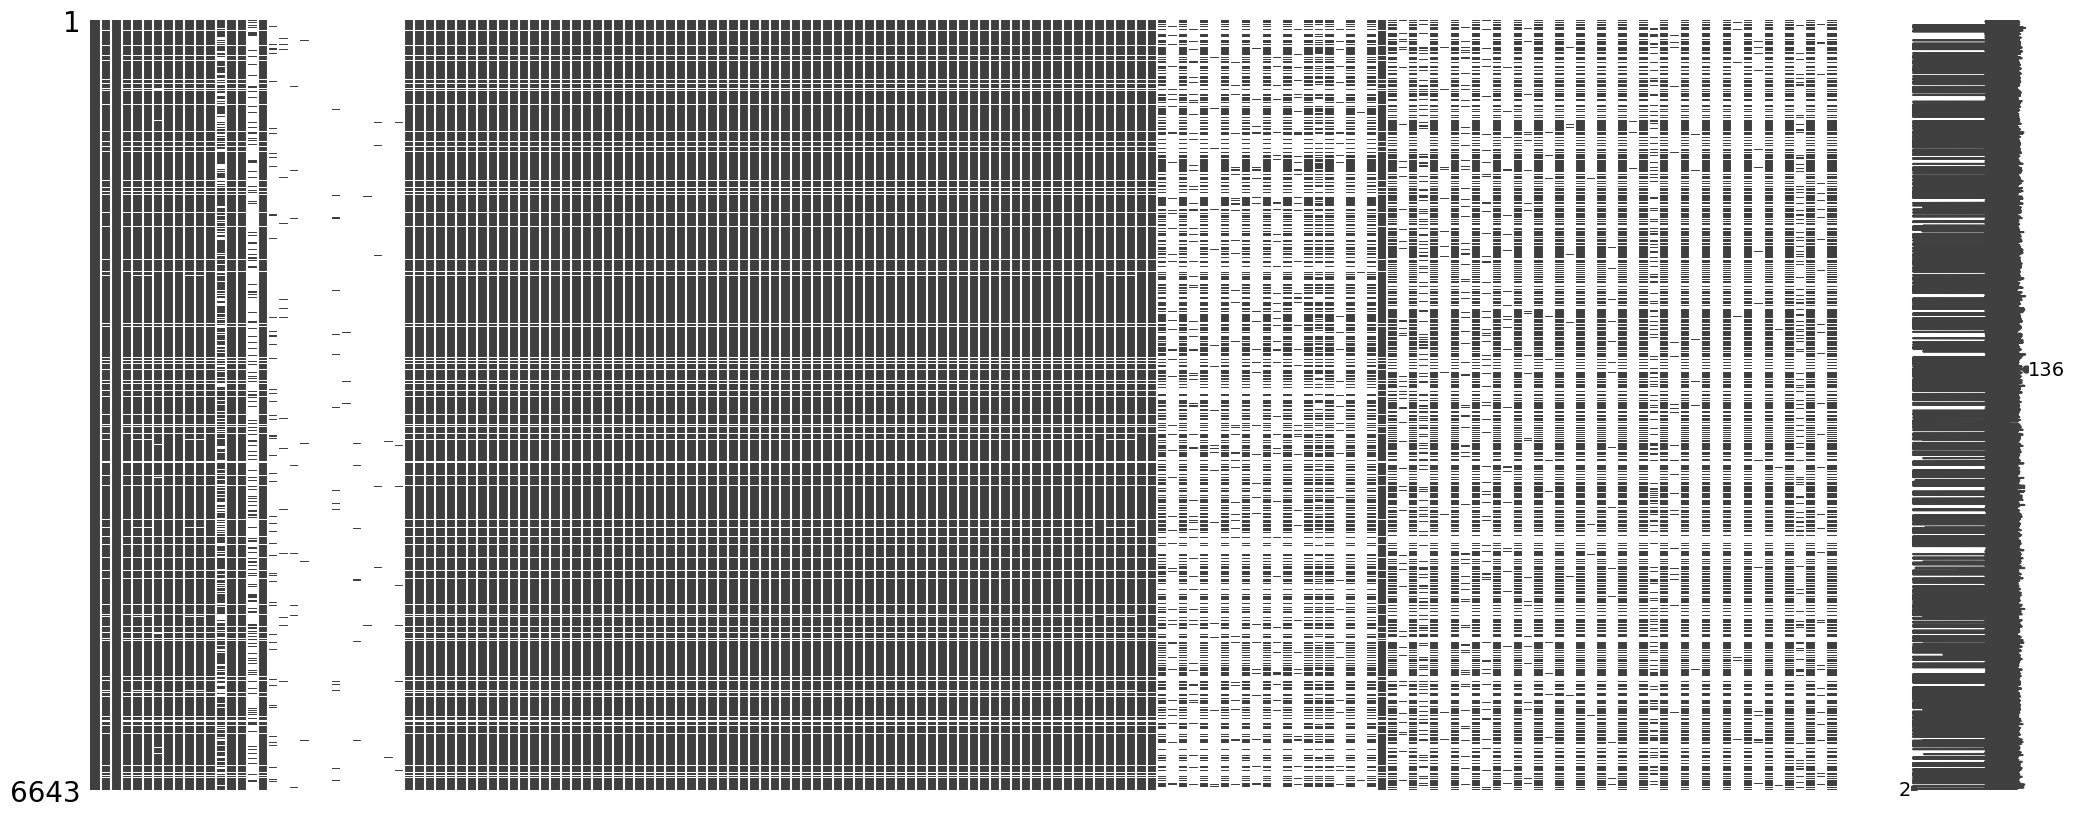

In [10]:
# Check for null values
import missingno as msno
msno.matrix(X);

In [11]:
# Importing further necessary packages
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [12]:
# We want to impute missing values. All features are numeric
cols = X_train.select_dtypes("number").columns
# Placing imputer
impute_median = SimpleImputer(strategy = "median")
# Placing scaler
scaler = StandardScaler()
# Making pipeline to transform data
pipe = make_pipeline(impute_median, scaler)
# Putting together tuple for column transformer
tuple = ('numeric', pipe, cols)

In [14]:
# Create the Column Transformer
col_transformer = ColumnTransformer([tuple], 
                                    verbose_feature_names_out=False)
col_transformer

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['WTDRD1', 'WTDR2D', 'DR1DRSTZ', 'DR1EXMER', 'DRABF', 'DRDINT',
       'DR1DBIH', 'DR1DAY', 'DR1LANG', 'DR1MNRSP',
       ...
       'DRD370QQ', 'DRD370R', 'DRD370RQ', 'DRD370S', 'DRD370SQ', 'DRD370T',
       'DRD370TQ', 'DRD370U', 'DRD370UQ', 'DRD370V'],
      dtype='object', length=167))],
                  verbose_feature_names_out=False)

In [15]:
# fit the column transformer on X_train
col_transformer.fit(X_train)
# Transform X_train and X_test
X_train_tf = col_transformer.transform(X_train)
X_test_tf = col_transformer.transform(X_test)
X_train_tf.head()

,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,DBD100,DRQSPREP,DR1STY,DR1SKY,DRQSDIET,DRQSDT1,DRQSDT2,DRQSDT3,DRQSDT4,DRQSDT6,DRQSDT7,DRQSDT8,DRQSDT9,DRQSDT10,DRQSDT11,DRQSDT12,DRQSDT91,DR1TNUMF,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TATOA,DR1TRET,DR1TVARA,DR1TACAR,DR1TBCAR,DR1TCRYP,DR1TLYCO,DR1TLZ,DR1TVB1,DR1TVB2,DR1TNIAC,DR1TVB6,DR1TFOLA,DR1TFA,DR1TFF,DR1TFDFE,DR1TCHL,DR1TVB12,DR1TB12A,DR1TVC,DR1TVD,DR1TVK,DR1TCALC,DR1TPHOS,DR1TMAGN,DR1TIRON,DR1TZINC,DR1TCOPP,DR1TSODI,DR1TPOTA,DR1TSELE,DR1TCAFF,DR1TTHEO,DR1TALCO,DR1TMOIS,DR1TS040,DR1TS060,DR1TS080,DR1TS100,DR1TS120,DR1TS140,DR1TS160,DR1TS180,DR1TM161,DR1TM181,DR1TM201,DR1TM221,DR1TP182,DR1TP183,DR1TP184,DR1TP204,DR1TP205,DR1TP225,DR1TP226,DR1.300,DR1.320Z,DR1.330Z,DR1BWATZ,DR1TWS,DRD340,DRD350A,DRD350AQ,DRD350B,DRD350BQ,DRD350C,DRD350CQ,DRD350D,DRD350DQ,DRD350E,DRD350EQ,DRD350F,DRD350FQ,DRD350G,DRD350GQ,DRD350H,DRD350HQ,DRD350I,DRD350IQ,DRD350J,DRD350JQ,DRD350K,DRD360,DRD370A,DRD370AQ,DRD370B,DRD370BQ,DRD370C,DRD370CQ,DRD370D,DRD370DQ,DRD370E,DRD370EQ,DRD370F,DRD370FQ,DRD370G,DRD370GQ,DRD370H,DRD370HQ,DRD370I,DRD370IQ,DRD370J,DRD370JQ,DRD370K,DRD370KQ,DRD370L,DRD370LQ,DRD370M,DRD370MQ,DRD370N,DRD370NQ,DRD370O,DRD370OQ,DRD370P,DRD370PQ,DRD370Q,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V
SEQN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
78468,-0.068376,2.451182,-0.305424,-1.540932,0.0,0.337702,-1.326313,-1.704660,-0.260182,-0.071893,0.076273,0.054331,0.266499,-0.163775,0.198887,-0.044883,0.166758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.075519,-0.133650,-0.327337,0.065522,0.056435,0.008182,-0.088552,-0.295955,0.075071,0.109790,0.551722,0.390464,-0.190864,0.162650,0.168138,0.418359,0.051469,0.049527,-0.561287,-0.130805,-0.134433,-0.274242,-0.099533,-0.247577,-0.285707,0.016930,-0.526238,-0.191913,0.050203,-0.152575,0.022185,-0.419829,0.150174,-0.024264,0.081567,-0.150158,-0.173197,0.703624,-0.601034,-0.240408,0.044529,-0.568038,0.418982,-0.666741,2.408652,-0.299254,-0.594949,-0.513961,-0.404426,-0.459602,-0.373255,-0.343181,-0.526365,-0.119641,-0.390854,-0.615180,0.175800,0.290435,-0.095318,0.095634,0.176873,-0.194409,0.378534,-0.037406,-0.191790,0.529926,-0.193818,-0.255919,-0.546023,0.316590,-0.255223,0.524280,0.248611,-0.128862,0.325773,-0.143288,0.164331,-0.063604,0.245868,-0.106439,0.194166,-0.10313,0.203975,-0.095229,0.237023,-0.103,-0.252682,-0.092889,0.173753,-0.08527,0.051149,-0.024546,0.0,-0.472423,0.271490,-0.138477,-1.819255,-0.883636,0.12279,-0.060859,0.335855,-0.026182,0.27741,0.007595,0.183914,-0.02813,0.157103,-0.081546,0.117635,-0.052248,0.115869,-0.068867,0.034724,-0.019011,0.133316,-0.061356,0.076518,0.004178,0.524234,-0.104791,-5.656269,-0.096011,0.107581,-0.050958,0.031696,-0.014169,0.092206,-0.034548,0.153716,-0.07639,0.056762,-0.028201,-2.461028,-1.003727,0.207683,-0.028177,0.0
75491,-0.717686,-0.207208,-0.305424,0.240753,0.0,0.337702,-0.968817,0.708152,-0.260182,-0.071893,0.076273,0.054331,0.266499,-1.004939,0.198887,-0.044883,0.166758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.585550,-0.925624,-0.809001,-0.938352,-0.572974,-0.891859,-0.837004,-0.576759,-0.766854,-0.902970,-0.879174,-0.674251,-0.190864,-0.419692,-0.530697,-0.306613,-0.315313,-0.161101,-0.044812,-0.371212,-1.042399,-0.445823,-1.023919,-0.836587,-0.574280,-0.445213,-0.439701,-0.554336,-0.813090,-0.365200,-0.340309,-0.327774,-0.204239,-0.446586,0.249201,-0.387678,-0.822757,-1.101612,-0.672820,-0.834668,-0.967346,-0.691324,-0.906444,0.414268,-0.159400,0.245352,-0.506303,-0.151247,0.050997,-0.155018,0.059850,-0.156273,-0.035583,-0.686487,-0.679850,-0.611388,-0.767561,-0.648334,-0.290029,-0.894136,-0.725765,-0.164956,-0.875547,-0.203506,-0.348506,-0.323028,-0.193818,-0.534610,-0.080254,-0.506077,-0.255223,0.

In [22]:
# Use K nearest neighbors to evaluate data
from sklearn.neighbors import KNeighborsClassifier
# Instantiate default KNN
knn = KNeighborsClassifier()

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      1.00      0.90      4092
           1       0.52      0.04      0.07       431
           2       0.76      0.05      0.10       459

    accuracy                           0.83      4982
   macro avg       0.70      0.36      0.36      4982
weighted avg       0.80      0.83      0.76      4982



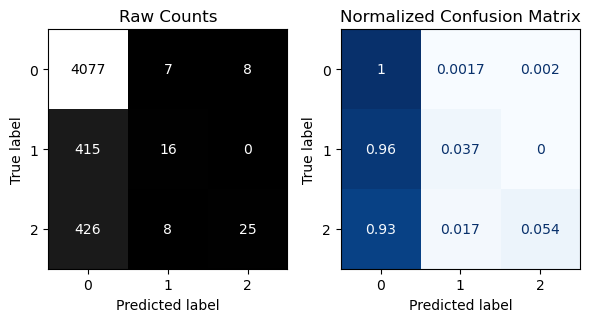


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.99      0.89      1360
           1       0.09      0.01      0.01       156
           2       0.15      0.01      0.03       145

    accuracy                           0.81      1661
   macro avg       0.35      0.34      0.31      1661
weighted avg       0.69      0.81      0.74      1661



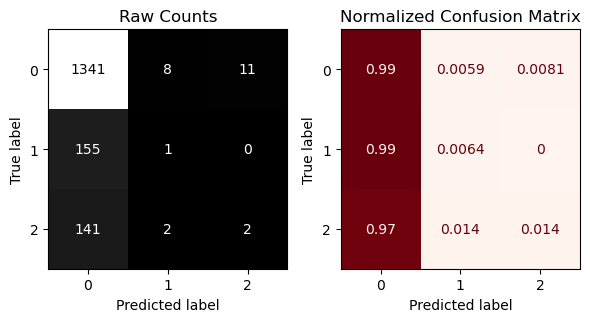

Training time was: 0:00:00.017990


In [19]:
# Record the time it takes to make predictions
# Import datetime library
import datetime as dt
# Record the start time
start = dt.datetime.now()
# Running scaled data through knn
knn.fit(X_train_tf, y_train)

# Record the end time and calc duration
end = dt.datetime.now()
dur_baseline = end-start

evaluate_classification(knn, X_train_tf, y_train, X_test_tf, y_test)
print(f'Training time was: {dur_baseline}')

In [25]:
# Define PCA to address 95% of the variance
pca95 = PCA(n_components=.95)
# fit and transform on training data
X_train_pca95 = pca95.fit_transform(X_train_tf)
# transform test data
X_test_pca95 = pca95.transform(X_test_tf)
# obtain the number of PCs used
pca95.n_components_

100

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      1.00      0.90      4092
           1       0.45      0.03      0.06       431
           2       0.71      0.04      0.08       459

    accuracy                           0.82      4982
   macro avg       0.66      0.36      0.35      4982
weighted avg       0.78      0.82      0.76      4982



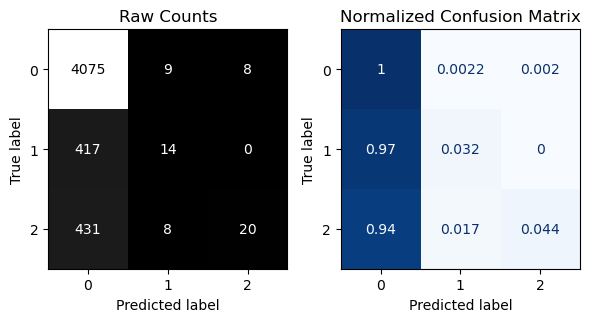


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.98      0.89      1360
           1       0.00      0.00      0.00       156
           2       0.17      0.02      0.04       145

    accuracy                           0.81      1661
   macro avg       0.33      0.33      0.31      1661
weighted avg       0.69      0.81      0.74      1661



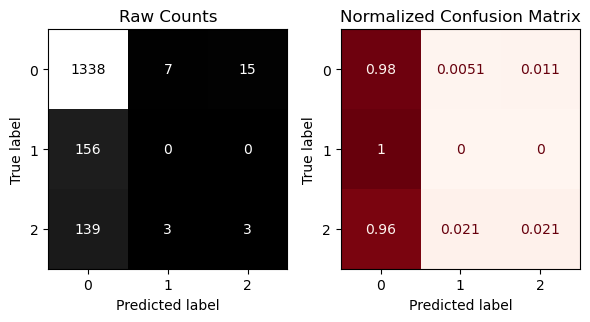

Training time was: 0:00:00.008997


In [26]:
# Record the start time
start = dt.datetime.now()
# Fit knn to PCA data
knn.fit(X_train_pca95, y_train)

# Record the end time and calc duration
end = dt.datetime.now()
dur_pca_95 = end-start

evaluate_classification(knn, X_train_pca95, y_train, X_test_pca95, y_test)
print(f'Training time was: {dur_pca_95}')

In [27]:
X_train_tf.shape

(4982, 166)

### Q1. How many features were used in the first model, and how many PCs were used in the PCA model?

#### There were 166 features in original knn model and 'only' 100 in PCA model

### Q2. Which model performed the best on the test set??

#### They are nearly identical, however based on slightly elevated precision, the first model seems to win out slightly

### Q3. Which model was the fastest at making predictions?

#### The second model was nearly twice as fast predicting. That makes sense as its using significantly fewer PCs than the first model was calculating features